In [1]:
%matplotlib inline

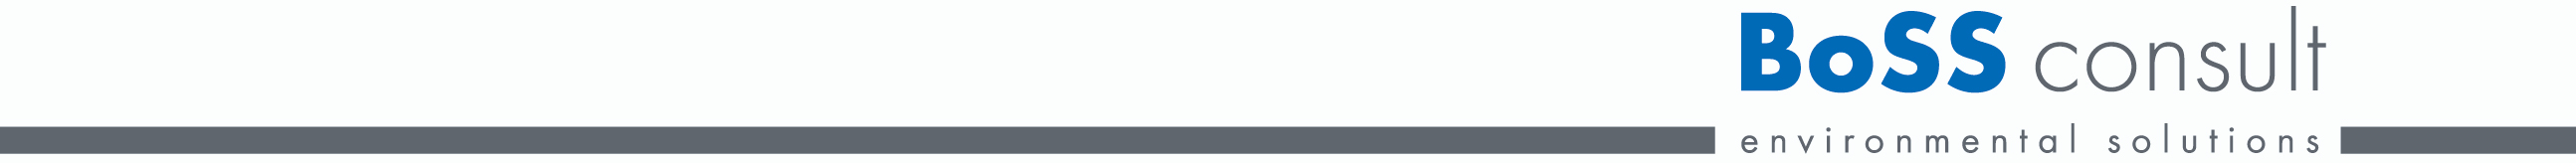

# Stationäre 2D-Brunnenströmung in Python

## Motivation

Planung einer hydraulischen Sanierung/Abstromsicherung für einen Schadstoffherd

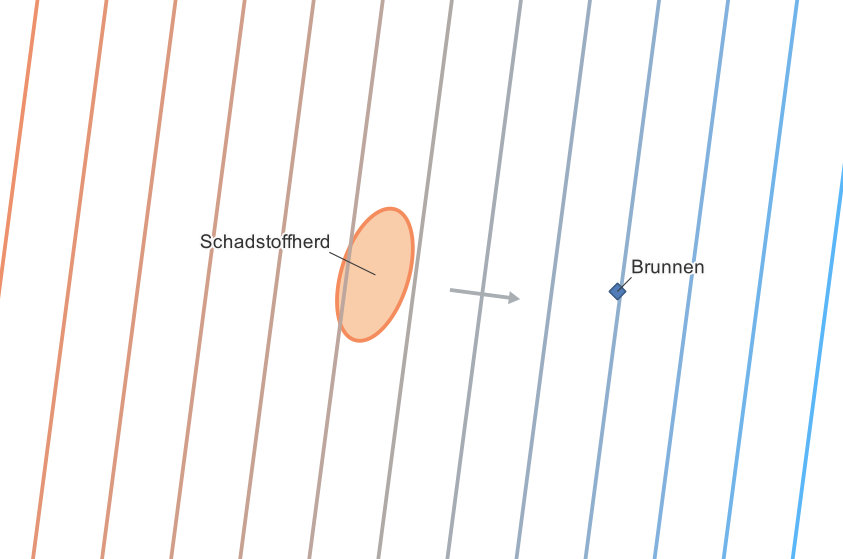

* An welcher Stelle soll der Brunnen gesetzt werden?
* Welche Entnahmerate ist erforderlich?
* Welche Grundwasserstände/Fließwege ergeben sich?

&rarr; Berechnung des Strömungsfelds $h(x,y)$ für einen Brunnen in einer Hintergrundströmung (inkl. Stromlinien und Entnahmebereich).

## Annahmen
* rein zweidimensionale Strömung im stationären Zustand
* unendliches Gebiet ohne Einwirkung von Rändern
* gespannter Grundwasserleiter mit Mächtigkeit $m$ (in m) und hydraulischer Durchlässigkeit $k_\mathrm{f}$ (in m/s), bzw. Transimissivität $T = m\cdot k_\mathrm{f}$ (in m²/s)
* gleichförmige Hintergrundströmung mit Gefälle $I$ (in m/m) und Fließrichtung $\alpha$ (in ° wobei 0° nach Norden und 90° nach Osten zeigt)
* Referenzpotential der Hintergrundströmung $h_\mathrm{ref}$ (in m) an der Stelle $(x_\mathrm{ref}|y_\mathrm{ref})$ (ohne Einfluss des Brunnens)
* vollkommener Brunnen mit Rate $Q$ (in m³/s) und Durchmesser $d$ (in m) an Position $(x_\mathrm{w}|y_\mathrm{w})$ ist einzige Quelle/Senke

## Python-Pakete
Wir laden die folgenden Pakete:
* `numpy`: für Vektor- und Matrizenrechnung
* `geopandas` und `shapely`: für den Import und Export von GIS-Dateien (z.B. Shapefile oder Geopackage)
* `matplotlib`: für die grafische Darstellung
* `colorcet`: für eine [gut zu interpretierende Farbskalierung](https://colorcet.com/)
* `locale`: für ein deutsches Zahlenformat (z. B. Komma statt Punkt)

In [2]:
# load packages
import numpy as np
import geopandas as gpd
from shapely import LineString,Point
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import colorcet as cc
import locale

## Parameterdefinitionen

Wir definieren die Parameter des Grundwasserleiters.

In [19]:
# define aquifer settings
kf = 1.5e-3 # hydraulic conductivity in m/s
I = 2e-3 # ambient hydraulic gradient in m/m
m = 8 # aquifer thickness in m
alpha = 97.5 # angle of ambient flow in °
x_ref = 503040.1 # reference location x
y_ref = 5376067.0 # reference location y
h_ref = 123.4 # reference potential in m

Wir definieren die Parameter des Brunnens und des Eintragsbereichs.

In [4]:
# define well settings
x_well = 503030.0 # x location of well
y_well = 5376067.0 # y location of well
Q = -1*1e-3 # pumping rate in m³/s (negative --> extraction; positive --> injection)
d_well = 0.2 # well diameter in m

# load source zone
source_area = gpd.read_file('Eintragsbereich.gpkg')

Wir definieren weitere Einstellungen, z.B. zur Darstellung.

In [5]:
# other length settings
xmin = x_well-110
xmax = x_well+40
ymin = y_well-50
ymax = y_well+50
Lx   = xmax-xmin # domain length in m
Ly   = ymax-ymin # domain width in m
dx   = np.min([Lx/100,Ly/100]) # spatial resolution in m

# utility conversions
T = m*kf # transmissivity in m²/s
xy_well =  np.vstack([x_well,y_well])
alpha = alpha/360*2*np.pi
r_well = d_well/2 # well radius in m
if np.abs(Q) > 0:
    well_is_active = True
else:
    well_is_active = False
    

## Erstellen einer Abbildung

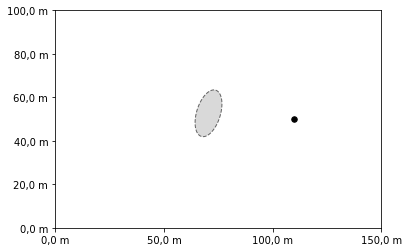

In [6]:
# initialize the plot
locale.setlocale(locale.LC_ALL, "de_DE.UTF-8")
mpl.rcParams['axes.formatter.use_locale'] = True

fig, ax = plt.subplots()
# plot source area
source_area.plot(ax=ax,facecolor="#d9d9d9", edgecolor="#636363",linestyle='dashed')
# plot well itself
ax.scatter(x_well,y_well,30,color='black',zorder=6)

ax.axis('scaled')
ax.xaxis.set_major_formatter(lambda val,pos: locale.format_string('%.1f m',val-xmin))
ax.yaxis.set_major_formatter(lambda val,pos: locale.format_string('%.1f m',val-ymin))

ax.set_xlim(left=xmin,right=xmax)
ax.set_ylim(bottom=ymin,top=ymax)
xticks =  ax.get_xticks()
yticks =  ax.get_yticks()
ax.set_xticks([tick - (xticks[0]-xmin) for tick in xticks])
ax.set_yticks([tick - (yticks[0]-ymin) for tick in yticks])

ax.set_xlim(left=xmin,right=xmax)
ax.set_ylim(bottom=ymin,top=ymax);

## Definition eines Modellgitters
* gleichmäßige Auflösung in x-Richtung
* prinzipiell gleichmäßige Auflösung in y-Richtung, aber: lokale Verfeinerung um $x=0$, da sich dort ein Sprung in der Stromfunktion befindet (Singularität)

In [7]:
# construct a grid for evaluation
x = np.arange(xmin,xmax,dx)
y1 = np.arange(ymin,y_well,dx)
y2 = np.arange(y_well,ymax,dx)
# for y we use a local refinement around the x-axis for improved precision at singularity
y = np.unique(np.concatenate([y1,np.linspace(y_well-dx,y_well+dx,8),y2])) 
X, Y = np.meshgrid(x, y, indexing='xy')

## Analytische Lösung Potentialfeld

$$ h(x,y) = h_\mathrm{ref}-I\begin{pmatrix}\sin(\alpha)\\\cos(\alpha)\end{pmatrix} \cdot\begin{pmatrix}x-x_\mathrm{ref}\\y-y_\mathrm{ref}\end{pmatrix} - \frac{Q}{2\pi T} \ln\left(\sqrt{(x-x_\mathrm{w})^2+(y-y_\mathrm{w})^2}\right) $$ 

&rarr; drei Komponenten:
1. Konstante $h_\mathrm{ref}$
2. Lineares Gefälle $-I\begin{pmatrix}\sin(\alpha)\\\cos(\alpha)\end{pmatrix} \cdot\begin{pmatrix}x-x_\mathrm{ref}\\y-y_\mathrm{ref}\end{pmatrix}$
3. Nichtlinearer Einfluss des Brunnens: $-\frac{Q}{2\pi T} \ln\left(\sqrt{(x-x_\mathrm{w})^2+(y-y_\mathrm{w})^2}\right) $


In [8]:
# analytical solution of hydraulic head field
def h_fun(X,Y):
    # determine distance from XY to well
    r = np.sqrt((X-x_well)**2+(Y-y_well)**2)
    # within the well, we use the well radius
    r = np.where(r < r_well, r_well, r)
    
    return h_ref - I * ( np.sin(alpha)*(X-x_ref) + np.cos(alpha)*(Y-y_ref) ) - Q/2/np.pi/T*np.log(r)

h = h_fun(X,Y)

# define contour level values
delta_h = I*np.sqrt(Lx*Ly)/11
print('h-Isolinien im Abstand von {} m.'.format(locale.format_string('%.3f',delta_h)))
lvls_h = np.arange(np.round(np.nanmin(h),2),np.nanmax(h),delta_h) # isoline values

h-Isolinien im Abstand von 0,022 m.


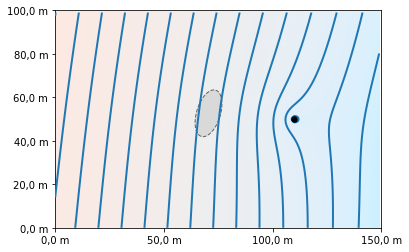

In [9]:
# plot gradient-colored background map
ax.pcolormesh(X, Y, h,cmap=cc.m_CET_D11,alpha=.2,edgecolors='none',zorder=0)

# plot and store contour lines 
potential_lines = ax.contour(X,Y,h,lvls_h,colors='#1f78b4',linewidths=2,zorder=3)

fig # show updated plot

## Stromfunktion
* in 2D-Problemen kann Stromfunktion $\psi$ berechnet werden:
$$ \frac{\partial \psi}{\partial x} = T \frac{\partial h}{\partial y} $$
$$ \frac{\partial \psi}{\partial y} = -T \frac{\partial h}{\partial x} $$
* Einheit: m³/s
* Menge an Wasser, die zwischen zwei Punkten fließt: $\psi(x_2,y_2)-\psi(x_1,y_1)$
* Isolinien entsprechen Stromlinien (senkrecht zu $h$-Potentiallinien)
* Zwischenräume der Isolinien entsprechen Stromröhren
* eigentlich gibt es die Stromfunktion *nur* in Problemen ohne Quellen- und Senken
* bei Brunnenströmung aber mit Trick anwendbar (führt zu Sprüngen auf der $x$-Achse)

## Analytische Lösung Stromfunktion für dieses Problem
$$ \psi(x,y) = (y\sin(\alpha)-x\cos(\alpha)) \cdot T \cdot I + \frac{Q}{2\pi} \arctan\left(\frac{y-y_\mathrm{w}}{x-x_\mathrm{w}}\right) + C_\psi $$ 

* $C_\psi$ ist frei wählbare Integrationskonstante 


In [10]:
# analytical solution of stream function
def psi_kernel(X,Y):
    return (Y*np.sin(alpha)-X*np.cos(alpha))* T*I + Q/2/np.pi*np.arctan2(Y-y_well,X-x_well)

def psi_fun(X,Y):
    psi = psi_kernel(X,Y)

    # modify integration constant such that psi is 0 on first bounding streamline
    psi = psi - psi_kernel(x_well+np.sin(alpha),y_well+np.cos(alpha))
        
    # set values directly on axis to NaN to account for jump across singularity
    sel = (X<x_well) & (np.abs(Y-y_well) <= 0.1*dx)
    psi = np.where(sel,np.nan,psi)

    return psi

# apply analytical solution of stream function
psi = psi_fun(X,Y)

In [11]:
# contour settings
psi_divisor = 6
if well_is_active:
    delta_psi = np.abs(Q)/psi_divisor; # contour line interval
else:
    delta_psi = T*I*np.sqrt(Lx*Ly)/psi_divisor; # contour line interval
    
print('Jede Stromröhre führt {} l/s.'.format(locale.format_string('%.3f',delta_psi*1000)))

# construct symmetric streamline isovalues
lvls_psi  = np.concatenate([np.arange(0,np.nanmax(psi),delta_psi),
                          Q,
                          np.arange(0,np.nanmin(psi),-delta_psi)
                         ],axis=None); 
lvls_psi = np.unique(lvls_psi);

Jede Stromröhre führt 0,167 l/s.


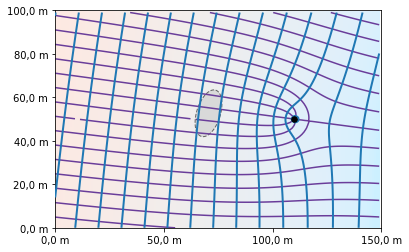

In [12]:
# append to plot
streamlines = ax.contour(X,Y,psi,lvls_psi,colors='#6a3d9a',linewidths=1.5,linestyles='solid',zorder=2)

# special case if flow is parallel to x axis
if (np.isclose(alpha,np.pi) or np.isclose(alpha,0.0)) and (psi_divisor % 2)==0:
    ax.plot([xmin,x_well],[y_well,y_well],color='#6a3d9a',linewidth=1.5,linestyle='solid',zorder=2)
fig # show updated plot

## Bestimmung der Entnahmebreite
Die Entnahmebreite $B_\mathrm{A}$ in m ergibt sich direkt aus der Entnahmerate und den Eigenschaften der Hintergrundströmung:

$$ B_\mathrm{A} = \frac{|Q|}{T \cdot I} $$ 

In [13]:
# add bounding streamlines
if well_is_active:
    # extraction width
    B_A = np.abs(Q)/(T*I)
    print('Entnahmebreite: {:.2f} m'.format(B_A))

Entnahmebreite: 41.67 m


## Trennstromlinien

Der Entnahmebereich des Brunnens wird durch diese Linie abgegrenzt:

$$ \begin{pmatrix}x_\mathrm{E}\\y_\mathrm{E}\end{pmatrix}  = \begin{pmatrix}x_\mathrm{w}\\y_\mathrm{w}\end{pmatrix} + \begin{pmatrix}\cos(\alpha+\frac{\pi}{2}) & \sin(\alpha+\frac{\pi}{2})\\ -\sin(\alpha+\frac{\pi}{2}) & \cos(\alpha+\frac{\pi}{2}) \end{pmatrix}  \cdot \begin{pmatrix}x_\mathrm{lokal}\\y_\mathrm{lokal}\end{pmatrix} $$

$$ y_\mathrm{lokal} \in \left(-\frac{B_A}{2},+\frac{B_A}{2}\right)  $$

$$ x_\mathrm{lokal} = y_\mathrm{lokal} \cdot \frac{1}{\tan\left(2\pi\cdot T \cdot I \cdot y_\mathrm{lokal} \cdot \frac{1}{Q}\right)}$$

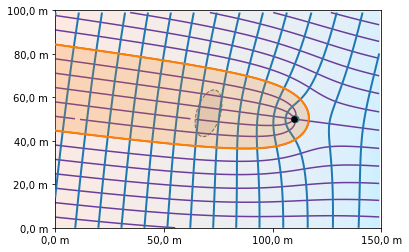

In [14]:
# add first bounding streamline
if well_is_active:
    # construct extraction outline in local coordinate system
    y_local   = np.linspace(-0.99,0.99,101)*0.5*B_A
    with np.errstate(divide='ignore',invalid='ignore'):
        x_local = y_local*(1/np.tan(2*np.pi*T*I*y_local/Q));
    xy_local = np.vstack([x_local,y_local])

    # go from local to global
    rot_matrix = np.array([[np.cos(alpha+0.5*np.pi), np.sin(alpha+0.5*np.pi)],
                           [-np.sin(alpha+0.5*np.pi), np.cos(alpha+0.5*np.pi)]])
    xy_E = np.dot(rot_matrix,xy_local) + np.vstack([x_well,y_well])

    # plot extraction outline
    ax.fill(xy_E[0,:],xy_E[1,:],linewidth=2,edgecolor='none',facecolor='#ff7f00',alpha=0.2,zorder=4)
    ax.plot(xy_E[0,:],xy_E[1,:],linewidth=2,color='#ff7f00',zorder=5)

fig # show updated plot

Eine zweite Trennstromlinie befindet sich hier:

$$ \begin{pmatrix}x_\mathrm{TS}\\y_\mathrm{TS}\end{pmatrix}  = \begin{pmatrix}x_\mathrm{w}\\y_\mathrm{w}\end{pmatrix} + p \cdot \begin{pmatrix}\sin(\alpha)\\\cos(\alpha)\end{pmatrix} $$ mit $ p \geq 0$

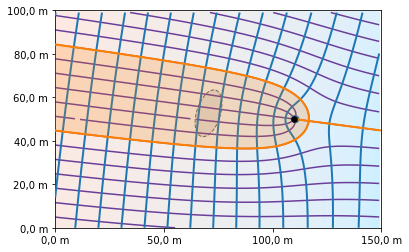

In [15]:
if well_is_active:   
    # second bounding streamline
    maxDist = np.nanmax(np.abs(x_local))
    p = maxDist * np.array([0,1])
    xy_TS = xy_well + p * np.vstack([np.sin(alpha),np.cos(alpha)]) 
    ax.plot(xy_TS[0,:],xy_TS[1,:],linewidth=2,color='#ff7f00',zorder=5)

fig # show updated plot

## Kulminationspunkt

Wo sich die beiden Trennstromlinien schneiden befindet sich ein Kulminationspunkt (auch Stagnationspunkt) mit Fließgeschwindigkeit $0$:

$$ \begin{pmatrix}x_\mathrm{SP}\\y_\mathrm{SP}\end{pmatrix}  = \begin{pmatrix}x_\mathrm{w}\\y_\mathrm{w}\end{pmatrix} + \frac{|Q|}{2\pi\cdot T \cdot I} \cdot \begin{pmatrix}\sin(\alpha)\\\cos(\alpha)\end{pmatrix} $$ mit $ p \geq 0$

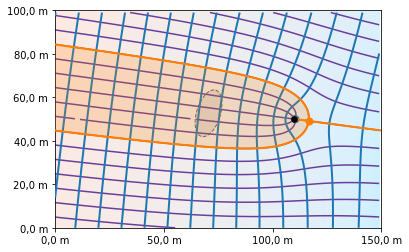

In [16]:
if well_is_active: 
    # stagnation point
    xy_KP = xy_well + np.abs(Q/2/np.pi/T/I) * np.vstack([np.sin(alpha),np.cos(alpha)]) 
    ax.scatter(xy_KP[0],xy_KP[1],50,color='#ff7f00',zorder=6)
fig  # show updated plot

## Ergebnisse für GIS abspeichern
* bisher alles nur als Python/Matplotlib-Grafik
* Export als Geopackage oder Shapefile mit `shapely` und `geopandas` möglich
* bei Shapefile aber je ein Shapefile pro Element
* für die Isolinien benötigen wir eine Hilfsfunktion

In [17]:
# helper function to convert matplotlib contour output to LineStrings
# source: https://discourse.matplotlib.org/t/collections-attribute-deprecation-in-version-3-8/24164/14
def contours_to_linestring(contour_set):
    contours = []
    paths_by_layer = []
    for i, joined_paths_in_layer in enumerate(contour_set.get_paths()):
        separated_paths_in_layer = []
        path_vertices = []
        path_codes = []
        for verts, code in joined_paths_in_layer.iter_segments():
            if code == Path.MOVETO:
                if path_vertices:
                    separated_paths_in_layer.append(Path(np.array(path_vertices), np.array(path_codes)))
                path_vertices = [verts]
                path_codes = [code]
            elif code == Path.LINETO:
                path_vertices.append(verts)
                path_codes.append(code)
            elif code == Path.CLOSEPOLY:
                path_vertices.append(verts)
                path_codes.append(code)
        if path_vertices:
            separated_paths_in_layer.append(Path(np.array(path_vertices), np.array(path_codes)))
    
        paths_by_layer.append(separated_paths_in_layer)
    
    for i, paths_in_layer in enumerate(paths_by_layer):
        # Process path
        for path in paths_in_layer:
            if not path.vertices.size:
                continue
            # Check the number of vertices
            if len(path.vertices) < 2:
                continue
            # Create linestring if valid
            geom = LineString(path.vertices)
            if geom.is_valid:
                contours.append(geom)
    return contours

In [18]:
# export settings
myCRS = 'EPSG:25832' # reference coordinate system
filename_GPKG = "Strömung.gpkg" # output file

# collect all geometries and assign labels              
geometries = {
    'Potentiallinien': contours_to_linestring(potential_lines),
    'Stromlinien': contours_to_linestring(streamlines),
    'Brunnen': gpd.points_from_xy([x_well], [y_well])
}
if well_is_active:
    geometries_well = {
        'Erfassungsbereich': [LineString(xy_E.T)],
        'Trennstromlinie': [LineString(xy_TS.T)],
        'Kulminationspunkt': gpd.points_from_xy(xy_KP[0], xy_KP[1])
    }
    geometries.update(geometries_well)

# store each geometry in the same geopackage              
for label,geometry in geometries.items():
    gpd.GeoDataFrame(geometry=geometry,crs=myCRS).to_file(filename_GPKG,layer=label) 

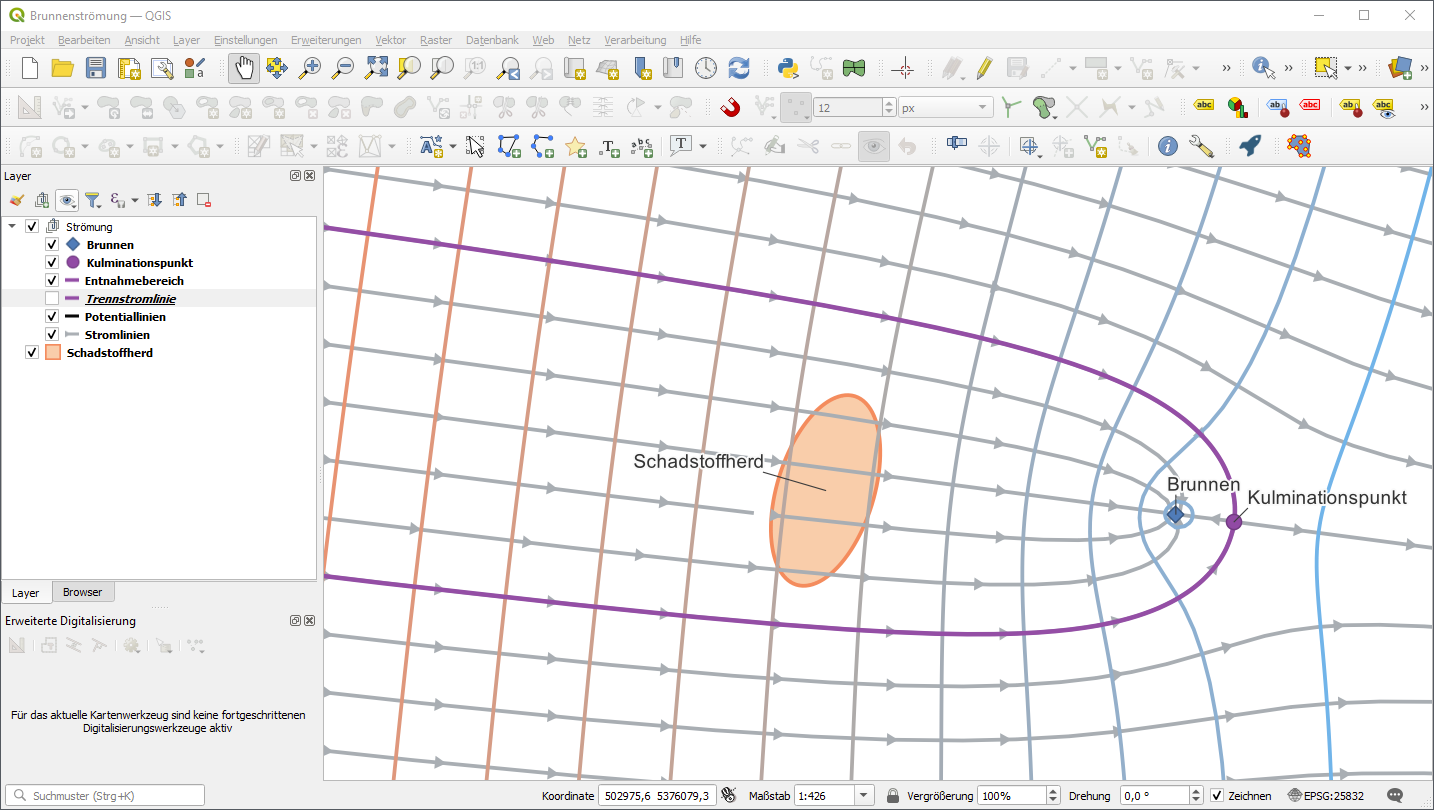

## Schlussbemerkungen
Die Gleichungen &amp; Codes können mit $Q>0$ auch für einen Injektionsbrunnen verwendet werden.

Das verwendete Koordinatensystem sollte rechtwinklig sein (z.B. EPSG 25832), da ansonsten Projektionsprobleme auftreten wenn das Betrachtungsgebiet zu groß ist. Ggf. sollte ein eigenes lokales Koordinatensystem eingeführt werden, von dem aus die Ergebnisse wieder auf das ursprüngliche Koordinatensystem projiziert werden.

Es sollte zu Beginn und zum Schluss immer überprüft werden, inwieweit die zugrundeliegenden Annahmen erfüllt oder verletzt sind.